The AB test is a randomized experiment that is used by most large companies to evaluate the launch of new functionality. Various difficulties may arise in the analysis and conduct of the experiment. Several typical problematic cases from real life are given in this dataset and analysis.

### Content
1. [Loading and processing data](#Loading)
2. [Statistical Analysis](#Statistical)
3. [Conclusions](#Conclusions)

### Loading and processing data <a name="Loading"/>

Let's import the necessary libraries and load the data

In [15]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

In [16]:
# TODO : import the dataset
import pandas as pd
df = pd.read_csv('/Users/teitelbaumsair/Desktop/Data Bootcamp/W8/D3/EXERCISE XP/AB_Test_Results.csv')

In [17]:
df.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [18]:
# TODO : take a quick look at the data
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [19]:
df.shape

(10000, 3)

Let's see if there are users who have two A/B test groups

In [43]:
# TODO : Look at the distribution of the number of unique groups for each user
unique_groups_per_user = df.groupby('USER_ID')['VARIANT_NAME'].nunique()
users_with_multiple_groups = unique_groups_per_user[unique_groups_per_user > 1]

print(f"Number of users out of 10,000 with more than one A/B test group: {len(users_with_multiple_groups)}")
print(users_with_multiple_groups)


Number of users out of 10,000 with more than one A/B test group: 1541
USER_ID
3        2
10       2
18       2
25       2
40       2
        ..
9978     2
9979     2
9982     2
9996     2
10000    2
Name: VARIANT_NAME, Length: 1541, dtype: int64


Relative Distribution of Unique Groups per User:
VARIANT_NAME
1    0.756325
2    0.243675
Name: proportion, dtype: float64


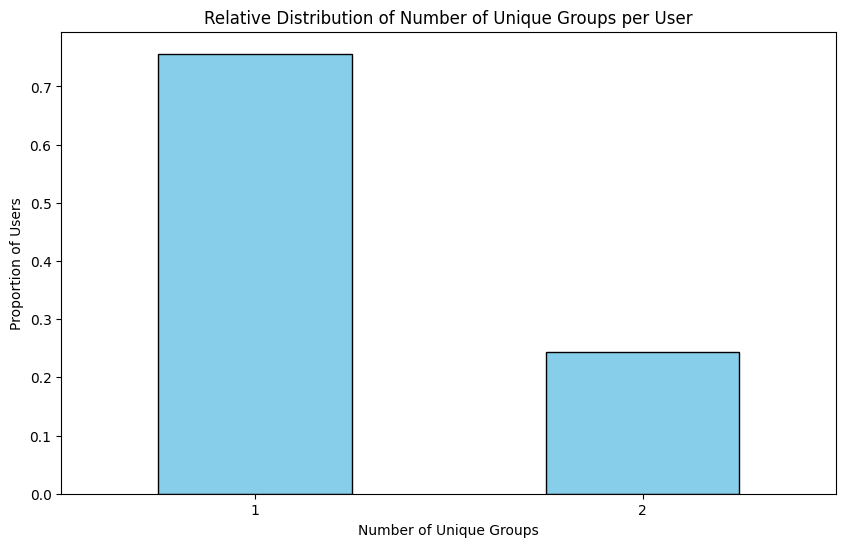

In [44]:
# TODO : Look at the distribution of the number of unique groups for each user in relative terms
relative_distribution = unique_groups_per_user.value_counts(normalize=True).sort_index()
print("Relative Distribution of Unique Groups per User:")
print(relative_distribution)

plt.figure(figsize=(10, 6))
relative_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Relative Distribution of Number of Unique Groups per User')
plt.xlabel('Number of Unique Groups')
plt.ylabel('Proportion of Users')
plt.xticks(rotation=0)
plt.show()

What can you observe ? Should we exclude these users ? Why ?

In [ ]:
# TODO : users have 1 A/B test group ?
AB_Test_Results = pd.DataFrame(df)
unique_groups_per_user = AB_Test_Results.groupby('USER_ID')['VARIANT_NAME'].nunique()
users_with_one_group = unique_groups_per_user[unique_groups_per_user == 1].index
filtered_data_one_group = AB_Test_Results[AB_Test_Results['USER_ID'].isin(users_with_one_group)]
original_user_count = AB_Test_Results['USER_ID'].nunique()
filtered_user_count = filtered_data_one_group['USER_ID'].nunique()
print(f"Original unique user count: {original_user_count}")
print(f"Filtered unique user count: {filtered_user_count}")
filtered_data_one_group.head()
# TODO : Take only these users
 

Original unique user count: 6324
Filtered unique user count: 4783


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
4,6174,variant,0.0
5,2380,variant,0.0
7,9168,control,0.0
9,7548,control,0.0


In [49]:
# TODO : Leave only records with users with the 1st ab test group

# TODO : Check that the number of users matches what it was before the exception

unique_groups_per_user = AB_Test_Results.groupby('USER_ID')['VARIANT_NAME'].nunique()
users_with_one_group = unique_groups_per_user[unique_groups_per_user == 1].index
filtered_data_one_group = AB_Test_Results[AB_Test_Results['USER_ID'].isin(users_with_one_group)]

# Verify that the number of users matches before and after the operation
original_user_count = AB_Test_Results['USER_ID'].nunique()
filtered_user_count = filtered_data_one_group['USER_ID'].nunique()

if original_user_count == filtered_user_count:
    print("User count matches. Filtering successful.")
else:
    print(f"User count mismatch! Original: {original_user_count}, Filtered: {filtered_user_count}")

User count mismatch! Original: 6324, Filtered: 4783


Let's see how the data is distributed

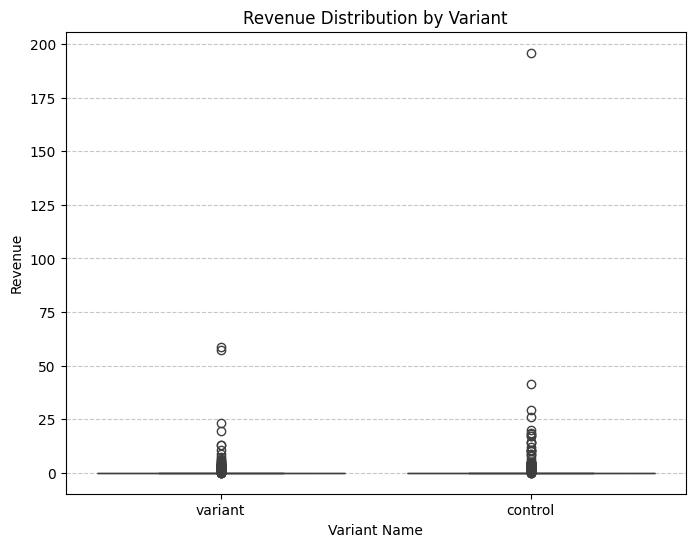

In [50]:
# TODO : Check how the data is distributed using a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=AB_Test_Results, x='VARIANT_NAME', y='REVENUE')
plt.title('Revenue Distribution by Variant')
plt.xlabel('Variant Name')
plt.ylabel('Revenue')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

It can be seen that there is a strong outlier in the data - we will find it by sorting these revenue values in descending order

In [51]:
# TODO : Sort these revenue values in descending order

sorted_data = AB_Test_Results.sort_values(by='REVENUE', ascending=False)
print(sorted_data)

      USER_ID VARIANT_NAME  REVENUE
1437     3342      control   196.01
6447     2881      variant    58.63
7642     7206      variant    57.46
9421     6792      control    41.53
8168     2166      control    29.32
...       ...          ...      ...
3356     7969      variant     0.00
3357     1184      control     0.00
3358     3775      variant     0.00
3359     6745      control     0.00
9999     9468      control     0.00

[10000 rows x 3 columns]


Events for User 3342:
       USER_ID VARIANT_NAME  REVENUE
1437      3342      control   196.01
10000     3342      control  1500.00


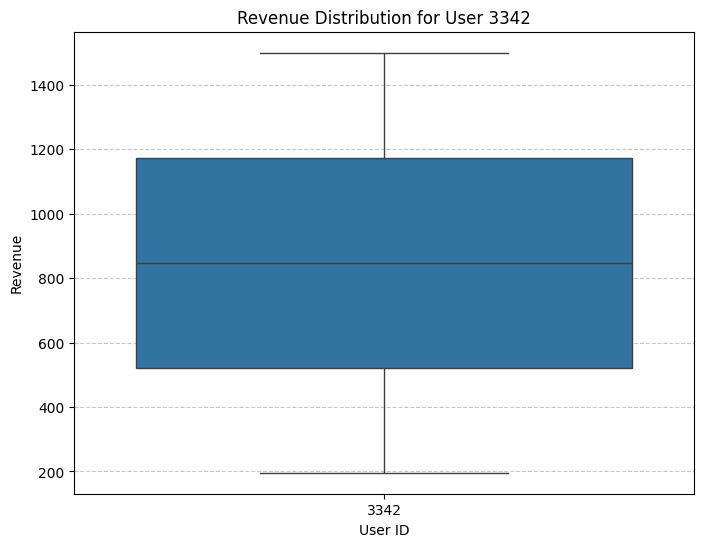

In [53]:
# TODO : See if user 3342 had other events with a strong outlier
new_row = pd.DataFrame({'USER_ID': [3342], 'VARIANT_NAME': ['control'], 'REVENUE': [1500.0]})
AB_Test_Results = pd.concat([AB_Test_Results, new_row], ignore_index=True)

# Filter the data for user 3342
user_3342_data = AB_Test_Results[AB_Test_Results['USER_ID'] == 3342]

# Display the data for user 3342
print("Events for User 3342:")
print(user_3342_data)

# Plot a box plot to visually identify outliers
plt.figure(figsize=(8, 6))
sns.boxplot(data=user_3342_data, x='USER_ID', y='REVENUE')
plt.title('Revenue Distribution for User 3342')
plt.xlabel('User ID')
plt.ylabel('Revenue')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We see that there is only one outlier - in conditions of limited information, we will remove this entry and look at the distribution of data again

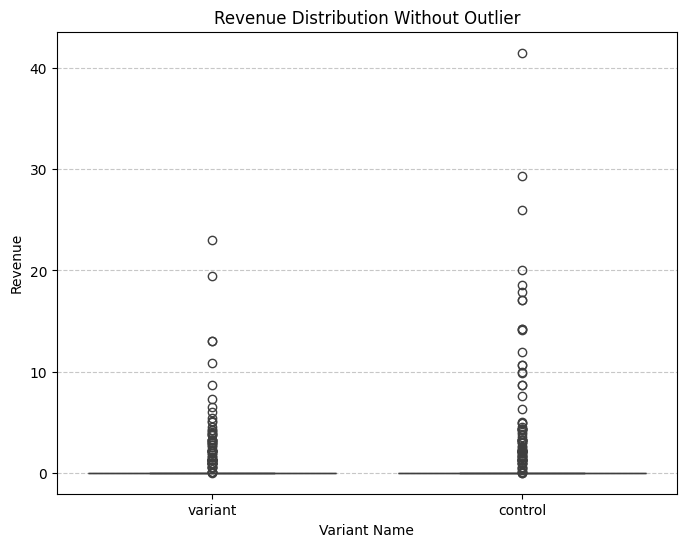

In [54]:
# TODO : We see that there is only one outlier - in conditions of limited information, remove this entry and visualize the distribution of data again.

threshold = 3  # Number of standard deviations from the mean to consider as outlier
revenue_mean = AB_Test_Results['REVENUE'].mean()
revenue_std = AB_Test_Results['REVENUE'].std()

# Compute outlier condition
outlier_condition = (AB_Test_Results['REVENUE'] - revenue_mean).abs() > threshold * revenue_std

# Identify and remove the outlier
AB_Test_Results_no_outlier = AB_Test_Results[~outlier_condition]

# Visualize the data without the outlier
plt.figure(figsize=(8, 6))
sns.boxplot(data=AB_Test_Results_no_outlier, x='VARIANT_NAME', y='REVENUE')
plt.title('Revenue Distribution Without Outlier')
plt.xlabel('Variant Name')
plt.ylabel('Revenue')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


What can you say about the users and their purchases ?

In [55]:
# TODO : Check if there are users who have records with zero and positive revenue
# Group by USER_ID and check if both zero and positive revenue exist
user_revenue_summary = AB_Test_Results.groupby('USER_ID')['REVENUE'].apply(lambda x: (x > 0).any() and (x == 0).any())

# Filter users with both zero and positive revenue
users_with_zero_and_positive_revenue = user_revenue_summary[user_revenue_summary].index
records_with_zero_and_positive_revenue = AB_Test_Results[AB_Test_Results['USER_ID'].isin(users_with_zero_and_positive_revenue)]

print("Users with both zero and positive revenue:")
print(users_with_zero_and_positive_revenue.tolist())

Users with both zero and positive revenue:
[124, 169, 282, 403, 443, 487, 618, 701, 702, 708, 828, 831, 839, 868, 1035, 1053, 1106, 1252, 1254, 1339, 1883, 1939, 2166, 2181, 2182, 2252, 2364, 2489, 2529, 2767, 2881, 3028, 3198, 3326, 3331, 3566, 3699, 3797, 4113, 4209, 4724, 4858, 4870, 4918, 5046, 5053, 5134, 5205, 5270, 5461, 5597, 5769, 5845, 5900, 6207, 6214, 6271, 6391, 6429, 6430, 6492, 6497, 6614, 6678, 6792, 7206, 7238, 7358, 7613, 7915, 7930, 8020, 8175, 8471, 8479, 8536, 8583, 8700, 8863, 8886, 8920, 8927, 8984, 9150, 9526, 9661, 9669, 9766, 9928, 9942, 9996]


Can a user have records with both zero and positive revenue ?

Let's make the assumption that the records are user visits to the service, and the experimental unit is users.


In [56]:
# TODO : Group the data for each user and sum the revenue for each to get one record per user
# Group by USER_ID and sum the REVENUE for each user
user_revenue_sum = AB_Test_Results.groupby('USER_ID')['REVENUE'].sum().reset_index()

# Display the result
print("Summed revenue for each user:")
print(user_revenue_sum)

Summed revenue for each user:
      USER_ID  REVENUE
0           2     0.00
1           3     0.00
2           4     0.00
3           5     0.00
4           6     0.00
...       ...      ...
6319     9993     0.00
6320     9995     0.00
6321     9996     6.46
6322     9998     0.00
6323    10000     0.00

[6324 rows x 2 columns]


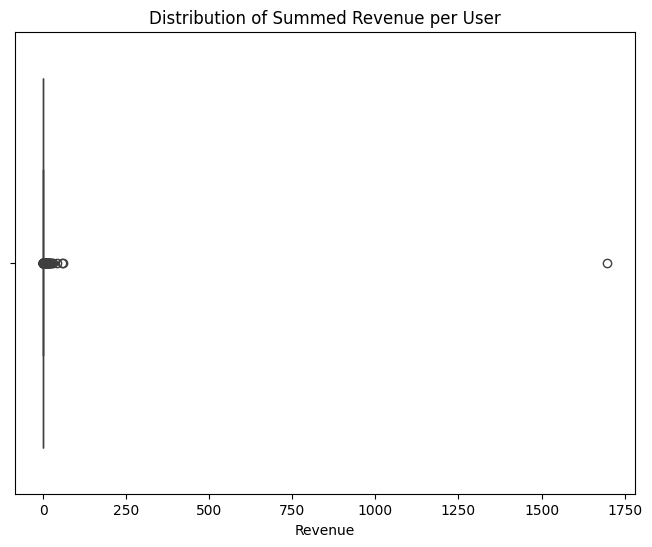

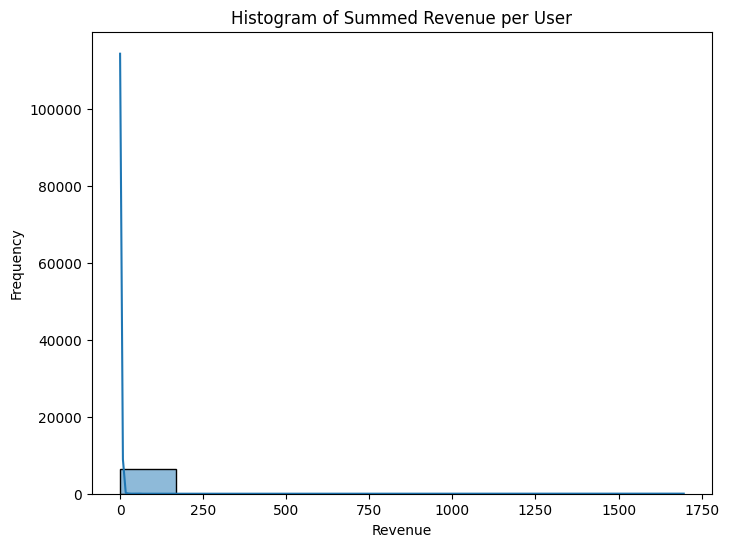

In [57]:
# TODO : Visualize the resulting distribution of the data again.

user_revenue_sum = AB_Test_Results.groupby('USER_ID')['REVENUE'].sum().reset_index()
plt.figure(figsize=(8, 6))

sns.boxplot(data=user_revenue_sum, x='REVENUE')
plt.title('Distribution of Summed Revenue per User')
plt.xlabel('Revenue')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(user_revenue_sum['REVENUE'], kde=True, bins=10)
plt.title('Histogram of Summed Revenue per User')
plt.xlabel('Revenue')
plt.ylabel('Frequency')

plt.show()

It should be noted that during the transformation, the quantiles in the test group increased

It can be seen that in the test group, almost all quantile statistics, except for the minimum, are at a slightly lower level.

Let's look at various statistics in the context of AB test groups for all users

In [58]:
# TODO : get metrics by groups


# TODO : create two additional metrics to see relative changes


# TODO : add them to the rest of the metrics in a separate group

grouped_metrics = AB_Test_Results.groupby('VARIANT_NAME').agg(
    total_revenue=('REVENUE', 'sum'),
    avg_revenue=('REVENUE', 'mean'),
    user_count=('USER_ID', 'nunique'),
    total_records=('USER_ID', 'count')
).reset_index()

control_total_revenue = grouped_metrics[grouped_metrics['VARIANT_NAME'] == 'control']['total_revenue'].values[0]
variant_total_revenue = grouped_metrics[grouped_metrics['VARIANT_NAME'] == 'variant']['total_revenue'].values[0]

control_avg_revenue = grouped_metrics[grouped_metrics['VARIANT_NAME'] == 'control']['avg_revenue'].values[0]
variant_avg_revenue = grouped_metrics[grouped_metrics['VARIANT_NAME'] == 'variant']['avg_revenue'].values[0]

relative_change_revenue = ((variant_total_revenue - control_total_revenue) / control_total_revenue) * 100
relative_change_avg_revenue = ((variant_avg_revenue - control_avg_revenue) / control_avg_revenue) * 100

grouped_metrics['relative_change_revenue'] = grouped_metrics['VARIANT_NAME'].apply(
    lambda x: relative_change_revenue if x == 'variant' else 0
)
grouped_metrics['relative_change_avg_revenue'] = grouped_metrics['VARIANT_NAME'].apply(
    lambda x: relative_change_avg_revenue if x == 'variant' else 0
)

print(grouped_metrics)

  VARIANT_NAME  total_revenue  avg_revenue  user_count  total_records  \
0      control        2143.00      0.42989        3931           4985   
1      variant         351.47      0.07007        3934           5016   

   relative_change_revenue  relative_change_avg_revenue  
0                  0.00000                     0.000000  
1                -83.59916                   -83.700521  


What can you see in the test group about the total amount of revenue, the average check per user, and the number of orders per user slightly increased ?

Let's also see how paying users behave :

In [59]:
# TODO : get metrics by groups


# TODO : create two additional metrics to see relative changes


# TODO : add them to the rest of the metrics in a separate group

grouped_metrics = AB_Test_Results.groupby('VARIANT_NAME').agg(
    total_revenue=('REVENUE', 'sum'),
    avg_revenue=('REVENUE', 'mean'),
    user_count=('USER_ID', 'nunique'),
    total_records=('USER_ID', 'count')
).reset_index()

control_total_revenue = grouped_metrics[grouped_metrics['VARIANT_NAME'] == 'control']['total_revenue'].values[0]
variant_total_revenue = grouped_metrics[grouped_metrics['VARIANT_NAME'] == 'variant']['total_revenue'].values[0]

control_avg_revenue = grouped_metrics[grouped_metrics['VARIANT_NAME'] == 'control']['avg_revenue'].values[0]
variant_avg_revenue = grouped_metrics[grouped_metrics['VARIANT_NAME'] == 'variant']['avg_revenue'].values[0]

relative_change_revenue = ((variant_total_revenue - control_total_revenue) / control_total_revenue) * 100
relative_change_avg_revenue = ((variant_avg_revenue - control_avg_revenue) / control_avg_revenue) * 100

relative_change_metrics = pd.DataFrame({
    'VARIANT_NAME': ['variant', 'control'],
    'relative_change_revenue': [relative_change_revenue, 0],
    'relative_change_avg_revenue': [relative_change_avg_revenue, 0]
})

final_metrics = pd.merge(grouped_metrics, relative_change_metrics, on='VARIANT_NAME', how='left')

print(final_metrics)


  VARIANT_NAME  total_revenue  avg_revenue  user_count  total_records  \
0      control        2143.00      0.42989        3931           4985   
1      variant         351.47      0.07007        3934           5016   

   relative_change_revenue  relative_change_avg_revenue  
0                  0.00000                     0.000000  
1                -83.59916                   -83.700521  


Let's look at the distributions of all and only paying users

/var/folders/_7/7nx4t_6s6995xg_cj866wrmr0000gn/T/ipykernel_63290/4101851425.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
/var/folders/_7/7nx4t_6s6995xg_cj866wrmr0000gn/T/ipykernel_63290/4101851425.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de4414

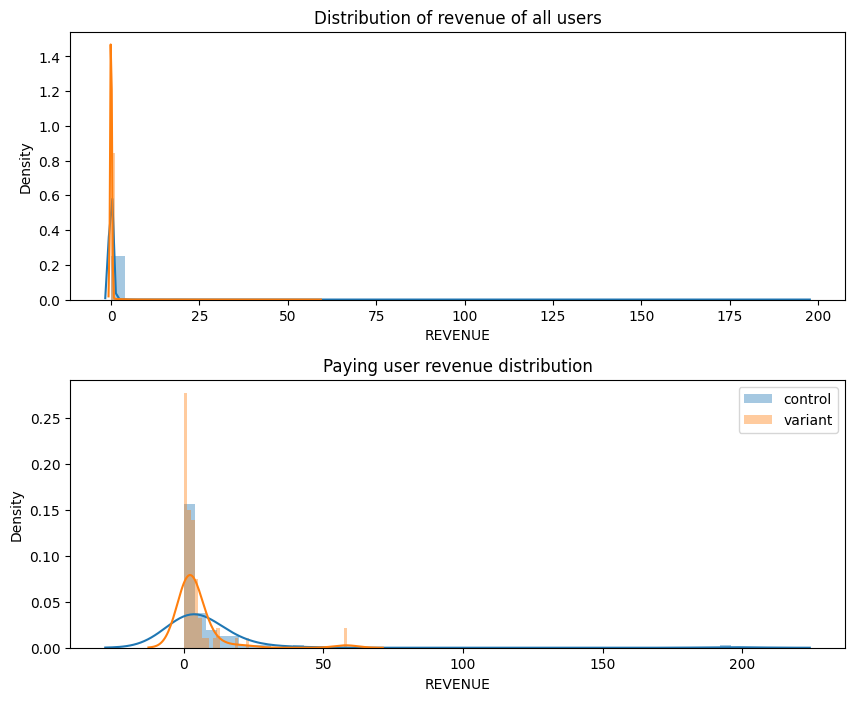

In [60]:
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# build graphs of distributions of paying users
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

### Statistical Analysis <a name="Statistical"/>

#### Checking if the distribution is normal

Based on their previous graph, we see that the data is not normally distributed.

In [63]:
# TODO : Use the Shapiro-Wilk criterion to confirm it
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
# Shapiro-Wilk test for normality
# All users (control group)
control_all_revenue = df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE']
stat, p_value_control_all = stats.shapiro(control_all_revenue)

# All users (variant group)
variant_all_revenue = df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE']
stat, p_value_variant_all = stats.shapiro(variant_all_revenue)

# Paying users (control group)
control_paying_revenue = df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE']
stat, p_value_control_paying = stats.shapiro(control_paying_revenue)

# Paying users (variant group)
variant_paying_revenue = df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE']
stat, p_value_variant_paying = stats.shapiro(variant_paying_revenue)

# Print results
print(f"Control group (all users) p-value: {p_value_control_all}")
print(f"Variant group (all users) p-value: {p_value_variant_all}")
print(f"Control group (paying users) p-value: {p_value_control_paying}")
print(f"Variant group (paying users) p-value: {p_value_variant_paying}")

# Interpretation
if p_value_control_all > 0.05:
    print("Control group (all users) is likely normally distributed.")
else:
    print("Control group (all users) is likely not normally distributed.")

if p_value_variant_all > 0.05:
    print("Variant group (all users) is likely normally distributed.")
else:
    print("Variant group (all users) is likely not normally distributed.")

if p_value_control_paying > 0.05:
    print("Control group (paying users) is likely normally distributed.")
else:
    print("Control group (paying users) is likely not normally distributed.")

if p_value_variant_paying > 0.05:
    print("Variant group (paying users) is likely normally distributed.")
else:
    print("Variant group (paying users) is likely not normally distributed.")

Control group (all users) p-value: 2.4983285100057203e-95
Variant group (all users) p-value: 2.7310104028899288e-95
Control group (paying users) p-value: 6.50334178109615e-18
Variant group (paying users) p-value: 2.114043206787204e-15
Control group (all users) is likely not normally distributed.
Variant group (all users) is likely not normally distributed.
Control group (paying users) is likely not normally distributed.
Variant group (paying users) is likely not normally distributed.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5016.
  res = hypotest_fun_out(*samples, **kwds)


Is the null hypothesis about the normal distribution of the data rejected ?

#### Mann-Whitney test

Let's check the value of the statistics of the Mann-Whitney test. Some sources have a limitation of applicability in case of duplicate data. There are a lot of repetitions in our sample, and especially a lot of zero values, so in this case we need to be careful about this criterion.

In [35]:
(df['REVENUE'] == 0).value_counts()

REVENUE
True     9848
False     152
Name: count, dtype: int64

In [36]:
# TODO : Check on the data of all users the value of the statistics of the Mann-Whitney test

In [37]:
# TODO : Check on the data of only the users that pay, the value of the statistics of the Mann-Whitney test

#### Bootstrap

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.

Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

In [38]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [39]:
# TODO : Generate samples for all users

In [40]:
# TODO : Generate samples for only paying users

Let's look at the distribution of means in the ab test groups

NameError: name 'control' is not defined

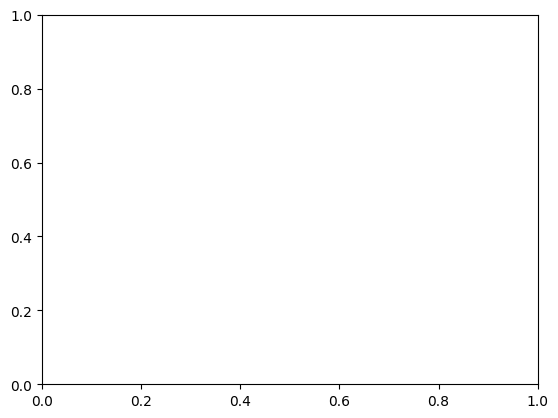

In [41]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for all users')

In [ ]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control_paid, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_paid, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for paying users')

Do you see any difference ? What about the confidence intervals ? Conclude.

Let's evaluate the difference between the groups: look at the distribution of the mean difference and build confidence intervals for it. To do this, we will create a function for visualization

In [ ]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """
    f, ax = plt.subplots()
    # get data for coloring confidence intervals
    points = sns.kdeplot(variant - control, shade=True).get_lines()[0].get_data()
    x = points[0]
    y = points[1]
    ymin, ymax = plt.ylim()
    # highlight the zero value and the bounds of the confidence interval
    plt.vlines(0, 0, ymax, label='0', color='gray')
    plt.vlines(stat_intervals(variant - control, alpha)[0], 0, ymax, linestyles="dashed")
    plt.vlines(stat_intervals(variant - control, alpha)[1], 0, ymax, linestyles="dashed")
    # color the confidence interval and zones outside it
    plt.fill_between(x,y,
                     where = (x >= stat_intervals(variant - control, alpha)[1]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = (x <= stat_intervals(variant - control, alpha)[0]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = ((x >= stat_intervals(variant - control, alpha)[0])
                              & (x <= stat_intervals(variant - control, alpha)[1])),
                     color='red',
                     label = '95% confidence interval')
    plt.title(f'Distribution of difference between means (variant - control) {title}; {100*(1-alpha)}% Confidence interval for difference of means: {stat_intervals(variant - control, alpha)}')
    plt.legend(prop={'size':13})
    # return confidence interval data
    return stat_intervals(variant - control)

Let's build a graph of the distribution of the difference in the means and get a confidence interval

For all users

In [ ]:
plot_distribution_and_stat_intervals(np.mean(variant, axis=1),
                                     np.mean(control, axis=1),
                                     title='all users')

In [ ]:
plot_distribution_and_stat_intervals(np.mean(variant_paid, axis=1),
                                     np.mean(control_paid, axis=1),
                                     title='paying users')

What can you observe ? Conclude about the statistical change in average revenue between A/B test groups.
